# Autoencoder & Variational Autoencoder am Beispiel von FashionMNIST

In dieser Aufgabe geht es darum, einen Autoencoder und einen Variational Autoencoder für den *FashionMNIST* Datensatz zu trainieren.

In [1]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt                # for plotting 
from tqdm.notebook import tqdm                 # provides smart progress bars

## Daten laden

Nachdem wir in der vorherigen Zelle wie üblich die benötigten Bibliothken importiert haben, laden wir nun zunächst wieder die Trainings- und Testdaten.

Im folgenden code wird der Datensatz in das Verzeichnis `/tmp` heruntergeladen, ein Verzeichnis, das für die Speicherung temporärer Daten vorgesehen ist und üblicherweise bei einer Reboot des Computers gelöscht wird.

In [2]:
batch_size = 512

transform_image = transforms.Compose([transforms.ToTensor(),])

trainset = FashionMNIST('/tmp/data', download=True, transform=transform_image, train=True)
testset  = FashionMNIST('/tmp/data', download=True, transform=transform_image, train=False)
train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=10, shuffle=True)
test_loader  = DataLoader(testset, batch_size=batch_size, num_workers=5, shuffle=True)

## Teil 1. Autoencoder: Definition des Encoders und Decoders

Der *Encoder* transformiert jedes Bild ($28 \times 28$ Pixel) in einen *latenten Raum* von niedriger Dimension. Die Dimension dieses Raumes sollten Sie als Parameter `latent_size` übergeben, damit wir die Größe später variieren können.

Als Architektur waren in verschiedenen Gruppen zwei Ansätze auszuprobieren:

- Ein einfaches Netz bestehend aus zwei [`Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) Layern mit [`ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) als Aktivierungsfunktion
- Ein mehrschichtiges CNN mit drei Blöcken aus [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [`BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) und [`ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html). Wie in der Aufgabe zur Bildklassifikation 
  sollten Sie dabei die Zahl der Pixel verringern und die Zahl der Kanäle erhöhen. Am Ende hängen Sie einen [`Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) Layer an, der das Bild in 
  den latenten Raum transferiert.

Zuerste definieren wir im nachfolgenden Code eine Klasse für den *Encoder*, der aus $3$ [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) Layern je mit nachgeschalteter [Batch Normalisierung](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) und [`ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) Aktivierungsfunktion besteht. Dann folgt ein [`Flatten Layer`](https://pytorch.org/docs/stable/generated/torch.flatten.html), der unsere Daten in einen Vektor umwandelt und nachgeschaltet $2$ [`Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) Layer mit [`ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) als Aktivierungsfunktion, die den eigentlichen *Bottleneck* also die niederdimensionale *latente* Repräsentation erzeugen.

Der *Decoder* wird als eigenständige Klasse definiert und besteht aus der umgekehrten Architektur wie der *Encoder*. Dabei existieren für die Invertierung der  [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) Layer, die [`ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) Layer. Als Aktivierungsfunktion am Ende des Decoders verwenden wir die [`sigmoid`](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) Funtion, um Grauwerte im Bereich zwischen 0 und 1 zu erzeugen.

Der *Encoder* und der *Decoder* werden dann in der entsprechenden Klasse einfach zum *Autoencoder* zusammengefasst.

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=25, hidden_size=512):
        super(Encoder, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(1),
            nn.Linear(128*16*16, hidden_size), # 128*16*16 = 32768
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size),
            nn.ReLU()
        )
  

    def forward(self, x):
        # call function defined in Encoder constructor
        x = self.main(x) 
        return x

class Decoder(nn.Module):
    def __init__(self, latent_size=25, hidden_size=512):
        super(Decoder, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 128*16*16),
            nn.Unflatten(-1, (128, 16, 16)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=5),
            nn.Sigmoid()
        )

    def forward(self, x):
        # call function defined in Decoder constructor
        x = self.main(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, latent_size=25):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(latent_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Die folgende Hilfsfunktion verwenden wir bei der Kontrollausgabe der Bilder

In [4]:
def to_image(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

## Vorbereitung des Trainings

Zum Training wählen wir eine geeignete `latent_size` (z.B. $32$), eine Verlustfunktion `criterion` und einen Optimizer aus. Der im nachfolgenden Code benutzte [`AdamW`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) Optimierungsalgorithmus unterscheidet sich von bereits besprochenen [`Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) Algorithmus nur geringfügig. Probieren Sie das Trainig ruhig für unterschiedliche Optimiser (oder Verlustfunktionen).

In [5]:
number_epochs = 51
learning_rate = 1e-4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')        # choose GPU using cuda if available
device = torch.device('mps' if torch.backends.mps.is_available() else device)  # choose mps for Apple M chips if available
print(f"Using device: {device.type}")

model = Autoencoder(latent_size=32)
model = model.to(device)

criterion = nn.MSELoss()
#criterion = nn.BCELoss()
#optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss = []
test_loss = []

Using device: cuda


In [6]:
def trainVanillaAutoEncoder(model, optimizer):
    with tqdm(range(number_epochs)) as iterator:
        for epoch in iterator:
            running_loss = 0
            count = 0
            for data in train_loader:
                optimizer.zero_grad()               # Clear gradients w.r.t. parameters

                image, i = data
                image = image.to(device)

                # Forward pass
                output = model(image)               # Forward pass to get output
                loss = criterion(output, image)     # Calculate loss

                # Backward pass
                loss.backward()                     # Getting gradients w.r.t. parameters
                optimizer.step()                    # Update parameters
                running_loss += loss.item()
                count += 1
            train_loss.append(running_loss/count)

            with torch.no_grad():
                running_loss = 0
                count = 0
                for data in test_loader:
                    image, i = data
                    image = image.to(device)

                    # Forward pass
                    output = model(image)            # Forward pass to get output
                    loss = criterion(output, image)  # Calculate loss
                    running_loss += loss.item()
                    count += 1
                test_loss.append(running_loss/count)

                iterator.set_postfix_str(f"Train Loss: {train_loss[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}")
                if epoch % 10 == 0:
                    # save an image eqach 10th epoch
                    rec = to_image(output.cpu().data)    # use to_image function defined above
                    img = to_image(image.cpu().data)
                    save_image(rec, f"rec_{epoch}.png")  # save image to hard disc
                    save_image(img, f"img_{epoch}.png")
                    
                    
trainVanillaAutoEncoder(model, optimizer)

  0%|          | 0/51 [00:00<?, ?it/s]

Nach dem Training sehen wir und die Verlustfunktionen für Trainings- und Test-Datensatz an und stellen fest, dass diese aussehen wie erwartet.

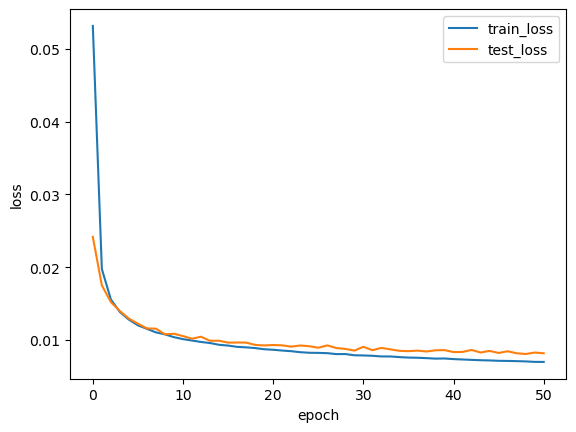

In [7]:
def plot_losses(train_loss,test_loss):
    plt.plot(range(len(train_loss)), train_loss, label="train_loss")
    plt.plot(range(len(test_loss)), test_loss, label="test_loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    
plot_losses(train_loss,test_loss)

Die mit [`save_image()`](https://pytorch.org/vision/main/generated/torchvision.utils.save_image.html) gespeicherten `*.png`-Dateien können wir im Anschluss wieder laden und darstellen (hier nur exemplarisch für die Epochen $0$ und $50$).

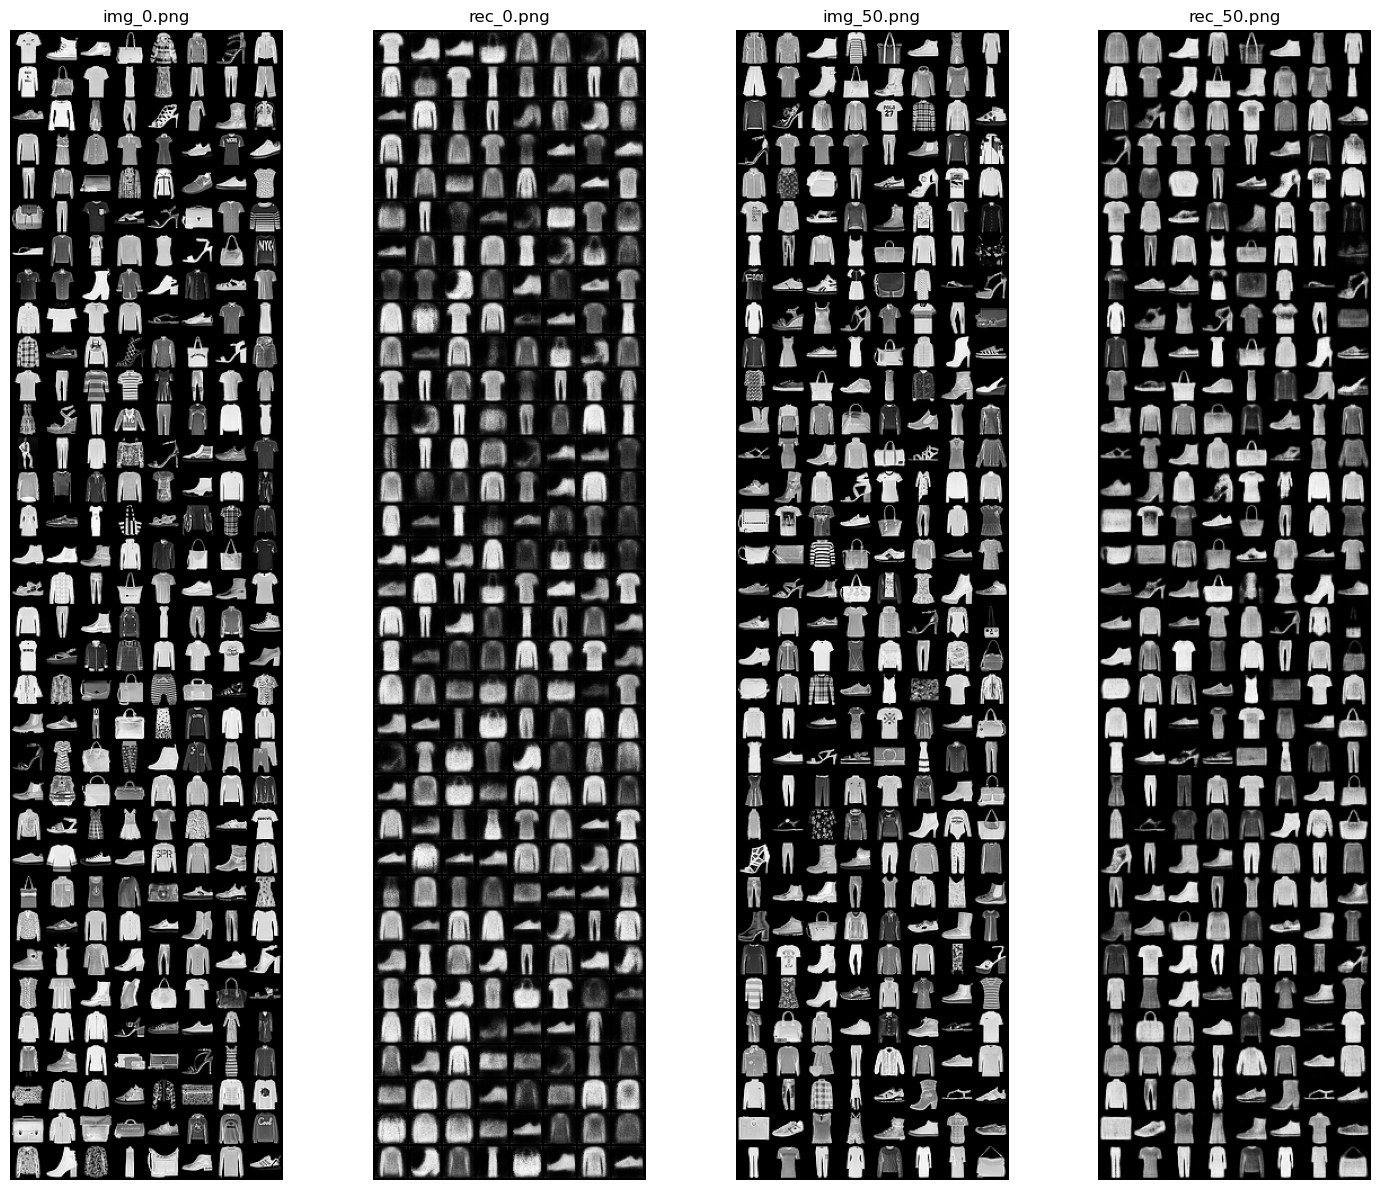

In [8]:
# Generate the list of image file names
img_files = [f'img_{i}.png' for i in range(0, number_epochs+1, 10)]  # ['img_0.png', 'img_10.png', ..., 'img_50.png']
rec_files = [f'rec_{i}.png' for i in range(0, number_epochs+1, 10)]  # ['rec_0.png', 'rec_10.png', ..., 'rec_50.png']

img_files = [img_files[0], rec_files[0], img_files[-1], rec_files[-1]] # only take epoch 0 and last one


def plot_img_files(img_files):
    # Prepare to plot the images
    num_images = len(img_files)
    fig, axs = plt.subplots(1, num_images, figsize=(15, 12))

    # Transform to convert images to tensors (if needed)
    # transform = transforms.ToPILImage()

    for ax, img_file in zip(axs, img_files):

        # Read the image as a tensor using PyTorch
        image_tensor = torchvision.io.read_image(img_file)  # Reads the image into a tensor

        # Convert the image tensor to a format suitable for plotting
        # PyTorch reads images in (C, H, W) format, need to permute to (H, W, C)
        image_tensor = image_tensor.permute(1, 2, 0)

        # Plot the image
        ax.imshow(image_tensor.numpy())  # Convert tensor to NumPy for plotting
        ax.axis('off')  # Hide the axis
        ax.set_title(img_file)

    plt.tight_layout()
    
plot_img_files(img_files)

## Teil 2: Variational Autoencoder

Beim Variational Autoencoder erzeugt der *Encoder* zu einer Eingabe keinen festen Ausgabevektor, sondern eine [Normalverteilung](https://de.wikipedia.org/wiki/Normalverteilung) $N(\mu, \sigma)$ (wobei $\mu$ und $\sigma$ der jeweilige Mittelwert und die Standardabweichung dieser Normalverteilung sind).

Der Encoder liefert dazu zwei Werte $\mu$ und $\log(\sigma),$ die jeweils die Dimension `latent_size` haben.

Mit diesen Parametern "würfelt" der Autoencoder einen Wert, den er dann an den *Decoder* übergibt. Dazu dient die Methode `reparametrize`

Die Verlustfunktion setzt sich dann aus dem Rekonstruktionsverlust $D_{RL}$ und der *Kullback-Leibler Divergenz* der Verteilung zur Standardnormalverteilung 

$$D_{KL}[N(\mu, \sigma)|| N(0, 1)] = -\frac{1}{2} \sum(1+ log(\sigma^2) - \mu^2 - \sigma^2)$$

zusammen:

$$D = D_{RL} + \beta D_{KL}.$$

Bei Vergleich des folgenden Codes für den *Encoder* mit dem *Encoder* des *vanilla Autoencoders* fällt auf, das der letzte Layer des *vanilla Autoencoders*, also

``` Python
nn.Linear(hidden_size, latent_size),
nn.ReLU()
```

ersetzt wurde und aus der [`nn.Sequential()`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) Funktion herausgelöst wurde. Stattdessen wurden zwei Lineare Layer implementiert, die die selben Eingangswerte haben, aber unterschiedliche Ausgangswerte erzeugen (um genau zu sein, Mittelwert $\mu$ und Standardabweichung $\sigma$). 

``` Python
self.mu = nn.Linear(hidden_size, latent_size)
self.logvar = nn.Linear(hidden_size, latent_size)
```

Diese Schichten liegen (da sie die gleichen Eingangswerte teilen) also parallel statt sequentiell, und sind daher auch nicht teil der [`nn.Sequential()`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) Funktion und müssen daher in der `forward()` Funktion separat aufgerufen werden.

Der *Decoder* bleibt unverändert.

Die Funktion implementiert den sogenannten **Reparametrisierungstrick**: Beim Training von VAEs müssen wir Stichproben aus einer Verteilung nehmen, um eine latente Variable zu erhalten, die an den Decoder übergeben werden kann. Der Probenahmeprozess selbst ist jedoch nicht differenzierbar, was verhindert, dass die Backpropagation während des Trainings wie gewohnt funktioniert. Der **Reparametrisierungstrick** adressiert dieses Problem, indem er den Sampling-Prozess auf differenzierbare Weise ausdrückt:

$$ z = \mu + \sigma \cdot \epsilon $$

- mit dem vom Encoder vorhergesagte Mittelwert $\mu$
- der vom Encoder vorhergesagte Standardabweichung $\sigma$ und
- einer Zufallsvariable $\epsilon$, die aus einer Standardnormalverteilung $N(0, 1)$ entnommen wird.

Auf diese Weise können wir das Sampling in eine Form umschreiben, die es ermöglicht, dass sich Gradienten während des *Backpropagation* Prozesses durch das Netzwerk ausbreiten.

In [9]:
class Encoder(nn.Module):
    def __init__(self, latent_size=25, hidden_size=512):
        super(Encoder, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(1),
            nn.Linear(128*16*16, hidden_size),
            nn.ReLU()
        )
        # Output for mean
        self.mu = nn.Linear(hidden_size, latent_size)
        # Output for log variance
        self.logvar = nn.Linear(hidden_size, latent_size)

    def forward(self, x):
        x = self.main(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar
    
class Decoder(nn.Module):
    def __init__(self, latent_size=25, hidden_size=512):
        super(Decoder, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 128*16*16),
            nn.Unflatten(-1, (128, 16, 16)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=5),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_size=64):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(latent_size)
        
    def reparametrize(self, mu, logvar):
        """
        Sample from a Gaussian distribution defined by mu and logvar 
        using the reparameterization trick for backpropagation.
        """ 
        # The following line computes the standard deviation by taking 
        # the exponential of half the logvar (since variance is the 
        # exponential of log-variance).
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_().to(device)
        # eps = Variable(eps)
        return eps.mul(std).add_(mu)
        
    def forward(self, x):
        mu, logvar = self.encoder(x)
        x = self.reparametrize(mu, logvar)
        x = self.decoder(x)
        return x, mu, logvar

In [11]:
class KLDLoss(nn.Module):
    """Calculate Kullback-Leibler divergence between learned mean and logvar 
    and standard normal distribution.
    This is *NOT* a re-implementation of torch.nn.KLDivLoss"""
    def __init__(self, reduction='mean'):
        super(KLDLoss, self).__init__()
        self.reduction = reduction

    def forward(self, mean, logvar):
        # KLD loss
        kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), 1)
        # Size average
        if self.reduction == 'mean':
            kld_loss = torch.mean(kld_loss)
        elif self.reduction == 'sum':
            kld_loss = torch.sum(kld_loss)
        return kld_loss

In [12]:
number_epochs = 51
learning_rate = 1e-3
if device is None:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

beta = 0.01

model = VariationalAutoencoder(32)
#model = VariationalAutoencoderFFOnly(32)
model = model.to(device)

reconstruction_loss = nn.MSELoss(reduction="sum")
kld_loss = KLDLoss(reduction="sum")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_loss = []
test_loss = []

In [13]:
def trainVariationalAutoEncoder(model, optimizer):
    with tqdm(range(number_epochs)) as iterator:
        for epoch in iterator:
            running_loss = 0
            count = 0
            model.train()
            for data in train_loader:
                optimizer.zero_grad()

                image, i = data
                image = image.to(device)

                # Forward pass
                output, mean, logvar = model(image)
                rc_loss = reconstruction_loss(output, image)
                kl_loss = kld_loss(mean, logvar)
                loss = rc_loss + beta * kl_loss

                # Backward pass
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                count += 1
            train_loss.append(running_loss/count)

            with torch.no_grad():
                running_loss = 0
                count = 0
                for data in test_loader:
                    image, i = data
                    image = image.to(device)

                    # Forward pass
                    output, mean, logvar = model(image)
                    rc_loss = reconstruction_loss(output, image)
                    kl_loss = kld_loss(mean, logvar)
                    loss = rc_loss + beta * kl_loss
                    running_loss += loss.item()
                    count += 1
                test_loss.append(running_loss/count)

                iterator.set_postfix_str(f"Train Loss: {train_loss[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}")
                if epoch % 10 == 0:
                    rec = to_image(output.cpu().data)
                    img = to_image(image.cpu().data)
                    save_image(rec, f"rec_{epoch}.png")
                    save_image(img, f"img_{epoch}.png")
                
trainVariationalAutoEncoder(model, optimizer)

  0%|          | 0/51 [00:00<?, ?it/s]

Wenn nachfolgend der Loss berechnet und angezeigt wird, so sind die absoluten Werte deutlich größer (was ok ist, da wir eine andere Loss-Funktion haben). Die prinzipielle Verlauf ist jedoch ähnlich.

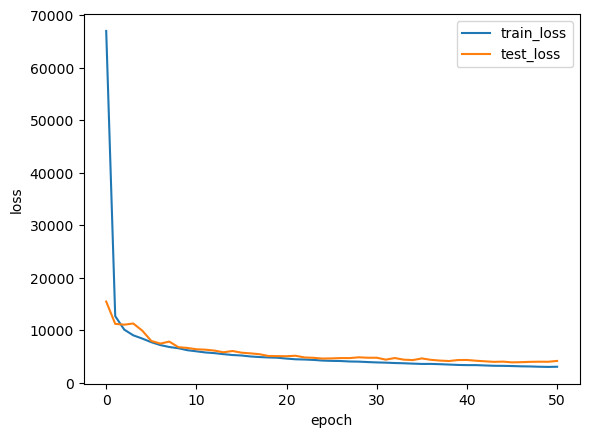

In [14]:
plot_losses(train_loss,test_loss)

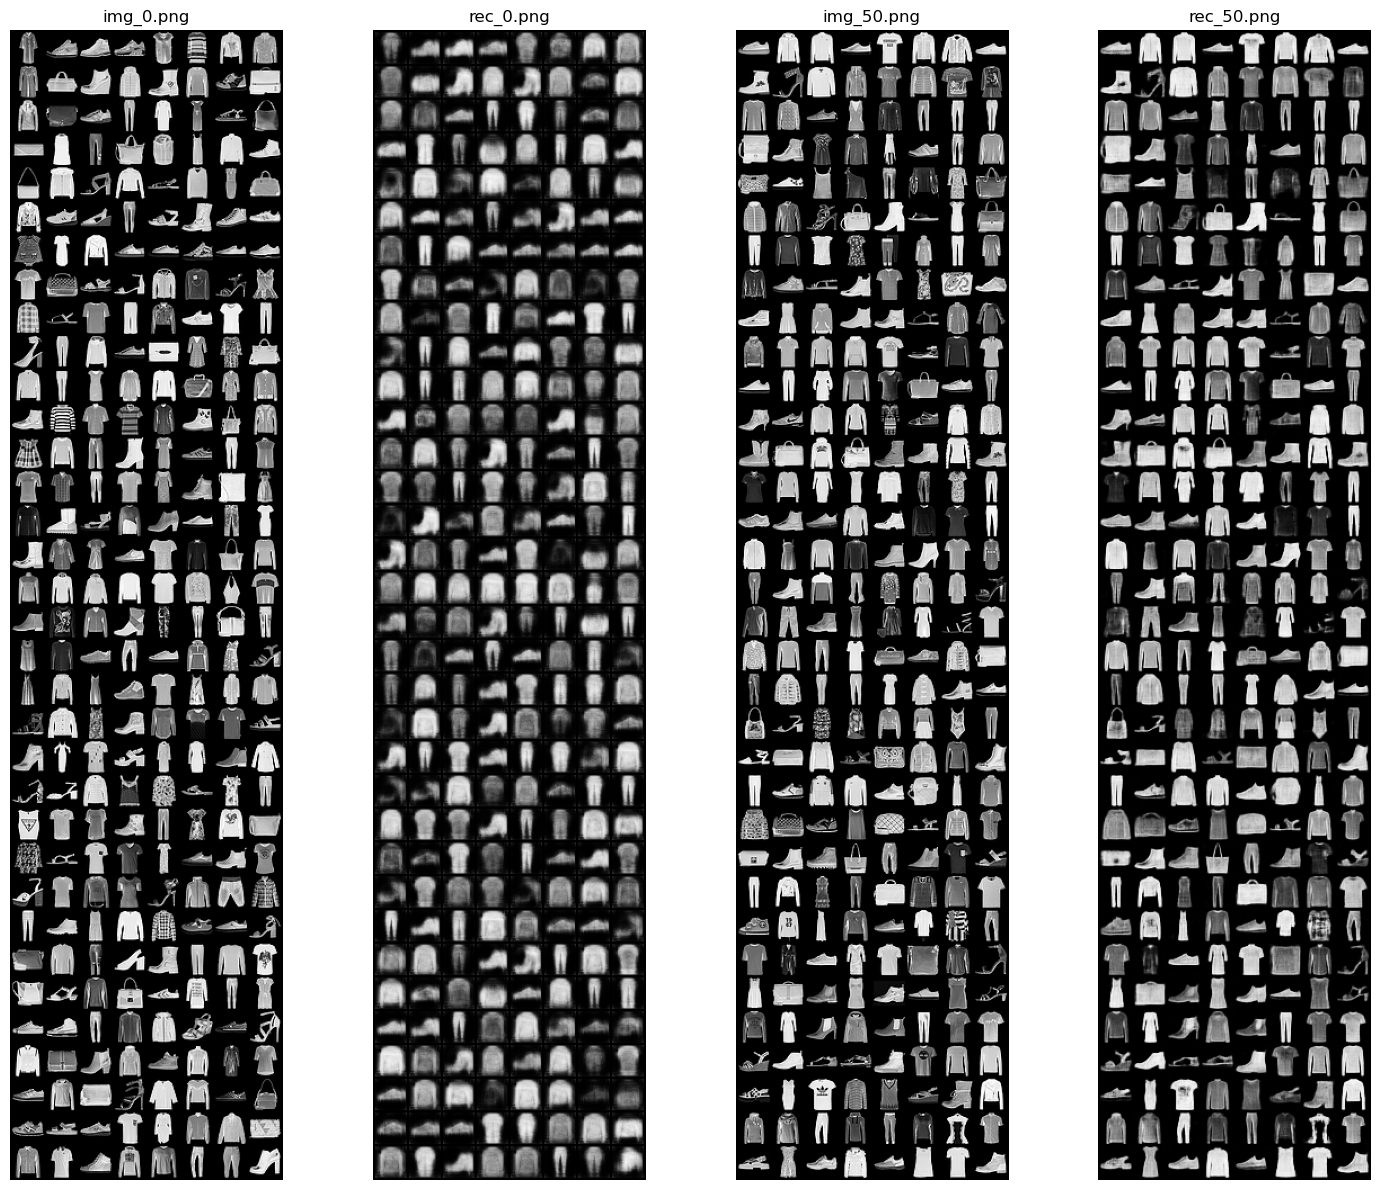

In [15]:
# Generate the list of image file names
img_files = [f'img_{i}.png' for i in range(0, number_epochs+1, 10)]  # ['img_0.png', 'img_10.png', ..., 'img_50.png']
rec_files = [f'rec_{i}.png' for i in range(0, number_epochs+1, 10)]  # ['rec_0.png', 'rec_10.png', ..., 'rec_50.png']

img_files = [img_files[0], rec_files[0], img_files[-1], rec_files[-1]] # only take epoch 0 and last one

plot_img_files(img_files)

Jetze das Gleiche noch mal mit dem Modell das lediglich Linear (feef forward) Layer benutzt:

Der nachfolgende Code ist eine Variante ohne CNNs, daher nennen wir die Klasse `VariationalAutoencoderFFOnly` um nachher eine der beiden Klassen auswählen zu können.

In [16]:
class VariationalAutoencoderFFOnly(nn.Module):
    def __init__(self, device=None):
        super(VariationalAutoencoderFFOnly, self).__init__()

        if device is None:
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.device = device
        
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode_function(self, x):
        x = x.view(image.size(0), -1)
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_().to(device)
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode_function(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3)).view(h3.size(0), 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode_function(x)
        z = self.reparametrize(mu, logvar)
        return self.decode_function(z), mu, logvar

In [17]:
model = VariationalAutoencoderFFOnly(32)
model = model.to(device)

reconstruction_loss = nn.MSELoss(reduction="sum")
kld_loss = KLDLoss(reduction="sum")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_loss = []
test_loss = []

In [ ]:
with tqdm(range(number_epochs)) as iterator:
    for epoch in iterator:
        running_loss = 0
        count = 0
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            
            image, i = data
            image = image.to(device)
  
            # Forward pass
            output, mean, logvar = model(image)
            rc_loss = reconstruction_loss(output, image)
            kl_loss = kld_loss(mean, logvar)
            loss = rc_loss + beta * kl_loss

            # Backward pass
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            count += 1
        train_loss.append(running_loss/count)
        
        with torch.no_grad():
            running_loss = 0
            count = 0
            for data in test_loader:
                image, i = data
                image = image.to(device)

                # Forward pass
                output, mean, logvar = model(image)
                rc_loss = reconstruction_loss(output, image)
                kl_loss = kld_loss(mean, logvar)
                loss = rc_loss + beta * kl_loss
                running_loss += loss.item()
                count += 1
            test_loss.append(running_loss/count)
                
            iterator.set_postfix_str(f"Train Loss: {train_loss[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}")
            if epoch % 10 == 0:
                rec = to_image(output.cpu().data)
                img = to_image(image.cpu().data)
                save_image(rec, f"rec_{epoch}.png")
                save_image(img, f"img_{epoch}.png")

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
plot_losses(train_loss,test_loss)

In [ ]:
# Generate the list of image file names
img_files = [f'img_{i}.png' for i in range(0, number_epochs+1, 10)]  # ['img_0.png', 'img_10.png', ..., 'img_50.png']
rec_files = [f'rec_{i}.png' for i in range(0, number_epochs+1, 10)]  # ['rec_0.png', 'rec_10.png', ..., 'rec_50.png']

img_files = [img_files[0], rec_files[0], img_files[-1], rec_files[-1]] # only take epoch 0 and last one

plot_img_files(img_files)